## Telco Customer Churn - StatsModel Log Regression

In [36]:
%matplotlib inline

import os
import sys
import json
import keras

from pathlib import Path
from pathlib import PureWindowsPath

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics

import lime
import lime.explanation 
import lime.lime_tabular

import shap


# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation


# Constants for Functions (Temporary)
ALGORITHM_NAME = 'lr'
COUNTRY = 'mwi'

In [37]:
# Change the default directory
os.chdir('/home/mike/Documents/mkp_code/Institute of Data Course/telco-customer-churn-project/data/processed')

In [38]:
# Upload Customer Churn data to dataframe
customer_data = pd.read_csv('Telco-Customer-Churn-Processed.csv')

In [39]:
# Drop Unnamed: 0 - This column is not needed
customer_data.drop('Unnamed: 0',axis=1,inplace=True)

In [40]:
# Divide the variables from the target column
target_col = ['Churn']

# Remove the target column
categorical_cols = customer_data.columns
categorical_cols = [col for col in categorical_cols if col not in target_col]

In [41]:
# Variables to a dataframe for processing
X= customer_data[categorical_cols]

In [42]:
# select y = Target Column - Churn
y = customer_data.Churn

In [43]:
# Store coefs for graphs
def get_coefs_df(X, coefs, index=None):
    coefs_df = pd.DataFrame(np.std(X, 0)*coefs)
    coefs_df.columns = ["coef_std"]
    coefs_df['coef'] = coefs
    coefs_df['abs'] = coefs_df.coef_std.apply(abs)
    if index is not None:
        coefs_df.index = index
    return coefs_df

In [44]:
# Partition the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [45]:
# Set the Logistic Regression
model = sm.Logit(y_train, x_train)
model = model.fit()

Optimization terminated successfully.
         Current function value: 0.425713
         Iterations 8


In [46]:
# Save coefs 
coefs = get_coefs_df(x_train, model.params)
coefs

,coef_std,coef,abs
gender,-0.003317,-0.006633,0.003317
SeniorCitizen,0.098607,0.267579,0.098607
Partner,0.015658,0.031353,0.015658
Dependents,-0.034114,-0.074915,0.034114
tenure,-1.404308,-1.404564,1.404308
PhoneService,-0.306364,-1.039258,0.306364
MultipleLines,0.069413,0.073144,0.069413
InternetService,0.171639,0.232869,0.171639
OnlineSecurity,-0.233598,-0.272218,0.233598
OnlineBackup,-0.128119,-0.145791,0.128119


In [47]:
# Run the model
y_prob = model.predict(x_train)
y_prob.head()

5925    0.159077
4395    0.347751
1579    0.719614
1040    0.669533
1074    0.218058
dtype: float64

In [48]:
# Define the y_pred
y_pred = (y_prob > 0.5)

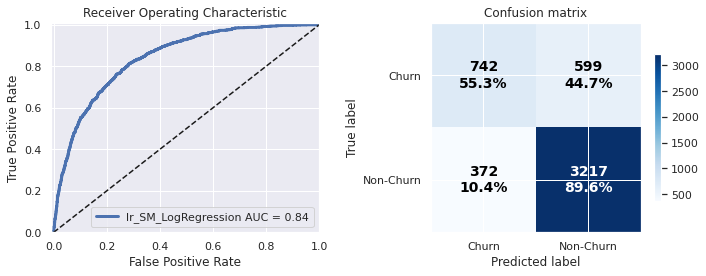

,lr_SM_LogRegression
accuracy,0.803043
recall,0.553318
precision,0.666068
f1,0.604481
cross_entropy,0.425713
roc_auc,0.841537
cohen_kappa,0.474842


In [49]:
# Evaluate performance
metrics = evaluation.evaluate_model(y_train, y_pred, y_prob, 
                                    store_model=True, 
                                    model_name='SM_LogRegression', 
                                    prefix=ALGORITHM_NAME, 
                                    country=COUNTRY, 
                                    model=model, 
                                    features=coefs)

In [50]:
# LIME has one explainer for all models 
explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values,          feature_names=x_train.columns.values.tolist(),                          class_names=['Churn'],                             categorical_features=categorical_cols,verbose=True, mode='regression')

Intercept 0.3760838237586049
Prediction_local [0.0864417]
Right: 0.06202361793172649


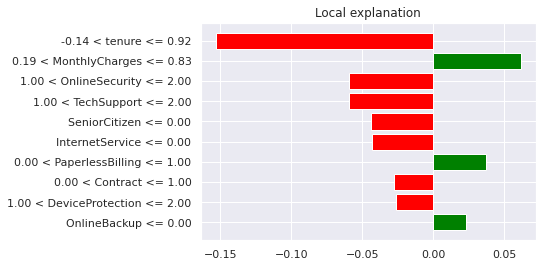

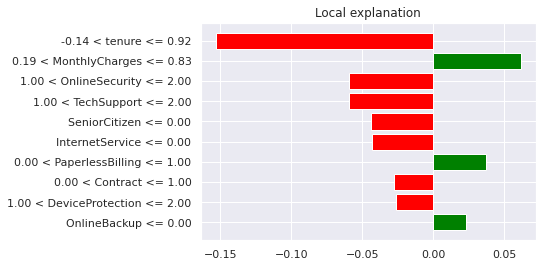

In [51]:
# Plot the explainer
exp = explainer.explain_instance(x_test.iloc[0], model.predict)
exp.as_pyplot_figure()

Intercept 0.24207289206309843
Prediction_local [0.29221058]
Right: 0.1270067088087354


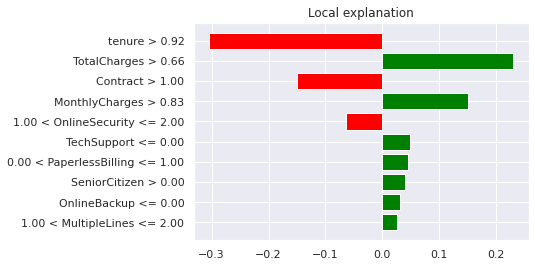

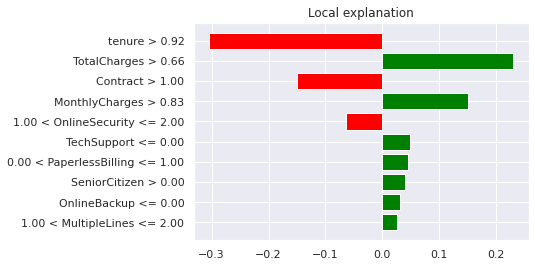

In [52]:
# Plot the explainer
exp = explainer.explain_instance(x_test.iloc[1], model.predict)
exp.as_pyplot_figure()

Intercept 0.142437583169561
Prediction_local [0.45494562]
Right: 0.34869415053283237


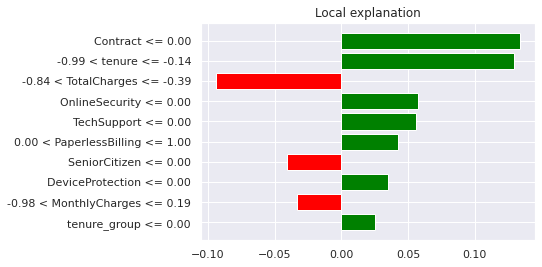

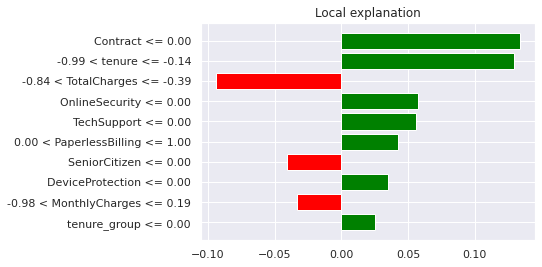

In [53]:
# Plot the explainer
exp = explainer.explain_instance(x_test.iloc[2], model.predict)
exp.as_pyplot_figure()

Intercept 0.08680751061952849
Prediction_local [0.53025917]
Right: 0.5116997336049246


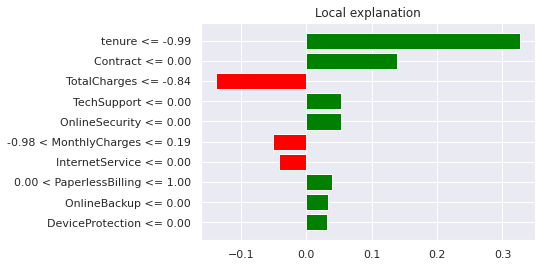

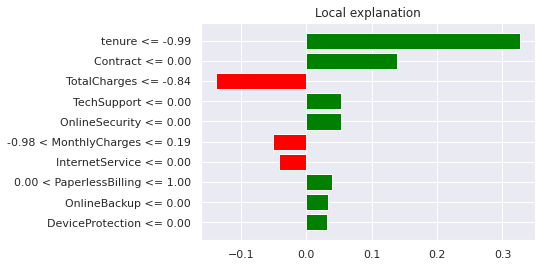

In [54]:
# Plot the explainer
exp = explainer.explain_instance(x_test.iloc[3], model.predict)
exp.as_pyplot_figure()

Intercept 0.30953375159020996
Prediction_local [0.23299727]
Right: 0.24009007856170436


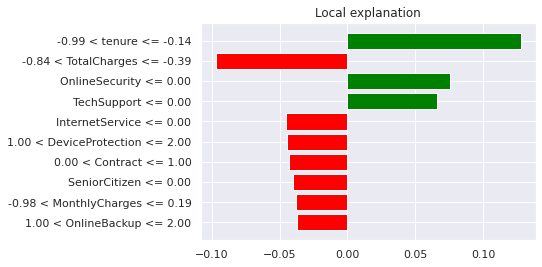

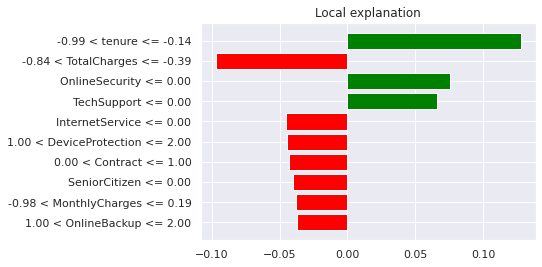

In [55]:
# Plot the explainer
exp = explainer.explain_instance(x_test.iloc[4], model.predict)
exp.as_pyplot_figure()

Intercept 0.2528387815937877
Prediction_local [0.31291022]
Right: 0.13395905954210718


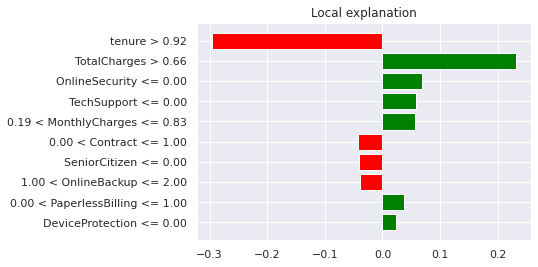

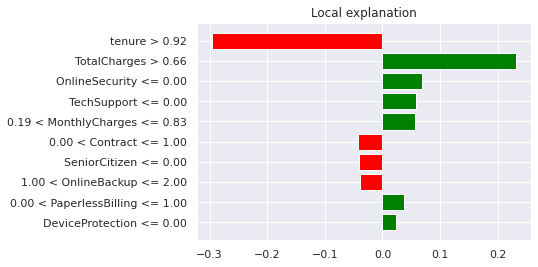

In [56]:
# Plot the explainer
exp = explainer.explain_instance(x_test.iloc[5], model.predict)
exp.as_pyplot_figure()

In [57]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2113 entries, 3381 to 4297
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            2113 non-null   int64  
 1   SeniorCitizen     2113 non-null   int64  
 2   Partner           2113 non-null   int64  
 3   Dependents        2113 non-null   int64  
 4   tenure            2113 non-null   float64
 5   PhoneService      2113 non-null   int64  
 6   MultipleLines     2113 non-null   int64  
 7   InternetService   2113 non-null   int64  
 8   OnlineSecurity    2113 non-null   int64  
 9   OnlineBackup      2113 non-null   int64  
 10  DeviceProtection  2113 non-null   int64  
 11  TechSupport       2113 non-null   int64  
 12  StreamingTV       2113 non-null   int64  
 13  StreamingMovies   2113 non-null   int64  
 14  Contract          2113 non-null   int64  
 15  PaperlessBilling  2113 non-null   int64  
 16  PaymentMethod     2113 non-null   int64

Intercept 0.24923621888005035
Prediction_local [0.30575439]
Right: 0.13395905954210718


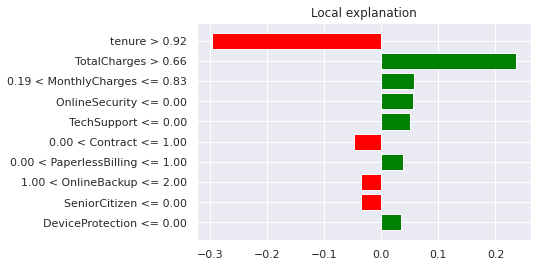

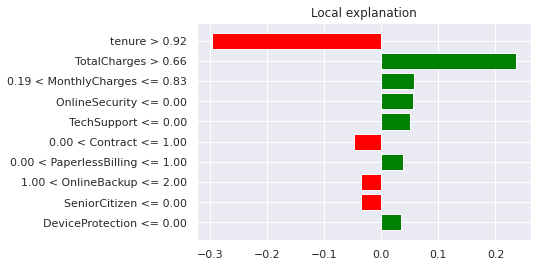

In [58]:
# Plot the explainer
exp = explainer.explain_instance(x_test.iloc[5], model.predict)
exp.as_pyplot_figure()

### Adopted from: 
#### Interpretability part 3: opening the black box with LIME and SHAP <br>https://www.kdnuggets.com/2019/12/interpretability-part-3-lime-shap.html



In [59]:
# Plot the explainer
exp = explainer.explain_instance(x_test.iloc[5], model.predict)
 
exp.show_in_notebook(show_table=True)

Intercept 0.2574409213707717
Prediction_local [0.29846791]
Right: 0.13395905954210718


In [35]:
# Plot the explainer
exp = explainer.explain_instance(x_test.iloc[5], model.predict)
exp.save_to_file('/home/mike/Documents/mkp_code/Institute of Data Course/telco-customer-churn-project/images/limeLogReg.html')

NameError: name 'LimeTabularExplainer' is not defined